# **Анализ A/B тестирования результатов скидок для сервисов "Жилая недвижимость"**

## Описание проекта

На сайте клининговой компании имеется сервис для владельцев жилой недвижимости, который предоставляет клининговые услуги по модели подписки (на месяц и на год), цены - 200 рублей и 1000 рублей соответственно. Продуктовая команда решила посмотреть каким образом скидки могли бы повлиять на аудиторию. Таким образом, было провелено A/B тестирование, при котором всех неплативших ранее и заходивших в период скидок пользователей поделили на группы А и В. Группе А не давали скидок, а группе В дали скидку 30%.

Метрики, на которые влияют скидки:

ARPU

Конверсия

Средний чек (так как из-за скидок пользователи могли изменить структуру приобретения подписок)

Задача состоит в том, чтобы подвести итоги А/Б-тестирования, рассчитав, насколько в группах А и Б различаются вышеописанные метрики.

Даты проведения тестирования: 2019-08-05 до 2019-08-11

ID теста: 127

**Описание данных**




*   ab_test_groups - в таблице представлены участники теста с разбивкой на группы
*   payments - в таблице содежится информация о платежах этих пользователей за время теста



**Импорты нужных библиотек и функций**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from statsmodels.stats import weightstats
from datetime import datetime
import statsmodels.stats.weightstats as ws
import math

**Подготовка данных**

In [ ]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups = ab_test_groups[ab_test_groups['ab_test_id']==127] # Так как ID нужного теста 127, выберем только такие строки.
payments = pd.read_csv('payments.csv')


**ab_test_groups - таблица пользователей**





* user_id - идентификатор пользователя
* grp - группа пользователя в А/В-тесте
* ab_test_id- идентификатор А/В-теста, в  котором принимает участие пользователь

**payments - таблица платежей**

* payment_id - идентификатор платежа
* user_id - идентификатор пользователя
* price - цена товара
* created_at - дата размещения заказа
* tariff - тариф или тип заказа

In [ ]:
# так как дата создания заказа имеет тип object, переведем его в datetime
payments['created_at'] = pd.to_datetime(payments['created_at'])
print(payments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14639 entries, 0 to 14638
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   payment_id  14639 non-null  int64         
 1   user_id     14639 non-null  int64         
 2   price       14639 non-null  float64       
 3   created_at  14639 non-null  datetime64[ns]
 4   tariff      14639 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 572.0+ KB
None


## Подсчет метрик
Название тарифа и дата совершения платежа не нужны для результатов А/В-теста. Поэтому нас будут интересовать только поля user_id и price. Также у нас ограничен период проведения теста — датами 2019-08-05 и 2019-08-11.

Выберем необходимые данные: проведём фильтрацию по дате через приведение столбца created_at к строковому типу данных. (Можно применять и другие подходы, но при таком формате данных такой способ самый простой.)

In [ ]:
payments = payments[(payments['created_at']>='2019-08-05') & (payments['created_at']<'2019-08-12')][['user_id','price']]
payments

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0
...,...,...
13701,2313,140.0
13702,139246,700.0
13703,42885,200.0
13704,129593,700.0


Как мы видим, данные устроены довольно просто: нам достаточно соединить эти две таблицы, чтобы осталась сводная информация обо всех участниках теста и покупках каждого из них за время теста.

Cоединим эти две таблицы, чтобы осталась сводная информация обо всех участниках теста и покупках каждого из них за время теста

In [ ]:
payments = payments.groupby(['user_id'], as_index = False)['price'].sum()
payments
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN
...,...,...,...,...
153227,153228,A,127,NaN
153228,153229,B,127,NaN
153229,153230,B,127,NaN
153230,153231,B,127,NaN


посмотрим, в каких пропорциях разбиты пользователи на группы и какое количество пользователей в каждой группе что-то купило.
Посчитаем долю пользователей в каждой группе
посчитаем средний чек покупки в каждой группе



In [ ]:
ab_summary = ab_data.groupby(['grp'], as_index = False)[['user_id','price']].count()
ab_summary = ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'})

ab_summary['users_count_share'] = ab_summary['users_count']/ab_summary['users_count'].sum()
ab_summary['buyers_count_share'] = ab_summary['buyers_count']/ab_summary['buyers_count'].sum()
ab_summary['conversion'] = (ab_summary['buyers_count'] / ab_summary['users_count'])

ab_summary = ab_summary.merge(ab_data.groupby(['grp'],as_index = False)['price'].mean().rename(columns = {'price':'avg_bill'}),
                on = 'grp', how='left')

ab_summary

,grp,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill
0,A,76605,4279,0.499928,0.312199,0.055858,396.120589
1,B,76627,9427,0.500072,0.687801,0.123025,348.804498


Несмотря на то что скидка в группе Б составляет 30%, средний чек упал на ~12%. Осталось подсчитать ARPU пользователей (среднюю выручку на пользователя в группе), а также дополнительную выручку, которую принесла группа Б.

Дополнительная выручка — это выручка, которую пользователи принесли дополнительно, если считать базовой выручку всех пользователей с ARPU, равным ARPU в контрольной группе.

In [ ]:
# Считаем общих доход
ab_summary = ab_summary.merge(ab_data.groupby(['grp'], as_index = False)['price'].sum().rename(columns = {'price':'revenue'}),
                 on='grp', how='left')
ab_summary.set_index('grp', drop=True)
# считаем arpu
ab_summary['ARPU'] = ab_summary['revenue']/ab_summary['users_count']
ab_summary = ab_summary.set_index('grp', drop=True)
ab_summary

,users_count,buyers_count,users_count_share,buyers_count_share,conversion,avg_bill,revenue,ARPU
grp,,,,,,,,
A,76605,4279,0.499928,0.312199,0.055858,396.120589,1695000.0,22.126493
B,76627,9427,0.500072,0.687801,0.123025,348.804498,3288180.0,42.911506


# Тестирование гипотез о разности параметров в группах A и B

## Конверсия
Рассчитаем значимость изменения конверсии.

##Постановка гипотезы
* H0: конверсия в группе А = конверсия в группе В (или конверсия А - конверсия В = 0)
* H1: конверсия в группе А < конверсия в группе В (конверсия А - конверсия В < 0) - т.е уровень конверсии вырос


## Наблюдения

* выборочная конверсия в группе А = 0.055858, количество пользователей в группе А = 76605
* выборочная конверсия в группе В = 0.123025, количество пользователей в группе В = 76627

Если гипотеза H0 верна, тогда разность выборочных конверсий (или по-другому пропорций) распределена нормально (по ЦПТ при достаточно большом n выборки пропорция распределена нормально) с матожиданием равным нулю и известным стандартным отклонением. Исходя из этого мы можем найти z статистику и соответствующее p-value.

В качестве уровня значимости альфа возьмем 0,05.


In [ ]:
z_test = ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),#Конверсии пользователей группы А
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) #Конверсии пользователей группы B
     )

print(' z статистика =', z_test[0], '\n', 'p-value =', z_test[1])

 z статистика = -46.38627328408593 
 p-value = 0.0


Таким образом, если H0 выполняется, то в данном случае вероятность получить наши наблюдаемые результаты настолько мала (значение p-value = 0.0 и явно меньше 0.05), что позволяет говорить о фактическом улучшении конверсии в группе В, то есть после введения скидки 30%.

## Средний чек и ARPU
Теперь рассмотрим различия среднего чека и ARPU.

## Проверка распределения на нормальность, тест Шапиро-Вилка




In [ ]:

print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())[1])


print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))[1])





Shapiro-Wilk p-value is 5.973228998538547e-75
Shapiro-Wilk p-value is 3.228116216458844e-170


Вывод: тест метрика не нормальна

## Тест Стьюдента и U-тест Манна-Уитни

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних не только T-тест, но и непараметрический U-тест Манна-Уитни. Несмотря на ненормальность распределения, в силу действия ЦПТ мы можем использовать Т-тест.

U-тест сообщит, различаются ли сами распределения, а T-тест покажет, различаются ли средние этих распределений. При сравнении средних величин (например, ARPU) обычно важнее показатель p-значение для Т-теста: если он меньше 0,05, а p-значение теста Манна-Уитни больше 0,05, то это всё равно говорит о значимых различиях показателей.

## Сравнение среднего чека

**Постановка гипотезы**

* H0: средний чек в группе А = средний чек в группе В (или средний чек А - средний чек В = 0)
* H1: средний чек в группе A > средний чек в группе B (средний чек A - средний чек B > 0) - т.е средний чек в В упал

**Наблюдения**

* выборочное среднее чека в группе А = 396.12
* выборочное среднее чека в группе В = 348.8
* Нет оснований полагать, что истинные стандартные отклонения чека в A и B равны.


Если гипотеза H0 верна, тогда разность выборочных средних чека распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением(по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). Исходя из этого мы можем найти t статистику и соответствующее p-value. Также дополнительно проводим U-тест.

В качестве уровня значимости альфа возьмем 0,05.

In [ ]:
# СРЕДНИЙ ЧЕК

# alternative='greater' потому что альтернативная гипотеза H1 звучит как
# "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
u_result_bill = stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna(),
                              alternative='greater')

# usevar='unequal' потому чтро нет оснований полагать, что истинные средние отклонения в А и В равны
# alternative='larger' потому что альтернативная гипотеза H1 звучит как
# "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
t_result_bill = weightstats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna(),
                     usevar='unequal', alternative='larger')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))

MannwhitneyuResult(statistic=28984683.0, pvalue=0.0)
Ttest_indResult 7.945395534593595 0.0000000000000011253


Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05 (0.0 у Манна-Уитни и 0.0000000000000011253 у Стьюдента), что говорит о том, что если бы истинные матожидания чеков в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные значения среднего чека была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве средних чеков в пользу альтернативной и считаем, что средний чек в А действительно значимо больше чем в В.

## Сравнение ARPU

**Постановка гипотезы**

* H0: ARPU в группе А = ARPU в группе В (или ARPU А - ARPU В = 0)
* H1: ARPU в группе A < ARPU в группе B (средний чек A - средний чек B < 0) - т.е ARPU в В выросло

**Наблюдения**

* выборочное ARPU в группе А = 22.13
* выборочное ARPU в группе В = 42.91
* Нет оснований полагать, что истинные стандартные отклонения доходов с каждого пользователя в A и B равны.
Если гипотеза H0 верна, тогда разность выборочных ARPU в А и В распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением(по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). Исходя из этого мы можем найти t статистику и соответствующее p-value. Также дополнительно проводим U-тест

В качестве уровня значимости альфа возьмем 0,05.

In [ ]:
# ARPU

# alternative='less' потому что альтернативная гипотеза H1 звучит как
# "разность ARPU А и В МЕНЬШЕ чем ноль"
u_result_arpu = stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0),
                              alternative='less')

# usevar='unequal' потому чтро нет оснований полагать, что истинные средние отклонения в А и В равны
# alternative='smaller' потому что альтернативная гипотеза H1 звучит как
# "разность ARPU А и В МЕНЬШЕ чем ноль"
t_result_arpu = weightstats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0),
                     usevar='unequal', alternative='smaller')

print(u_result_arpu)
print('Ttest_indResult', t_result_arpu[0], '{:.19f}'.format(t_result_arpu[1]))

MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult -29.8941861992998 0.0000000000000000000


Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05, что говорит о том, что если бы истинные матожидания дохода с каждого пользователя в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные ARPU была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве ARPU в А и В и считаем, что ARPU в B действительно значимо больше чем в A.

## Доверительные интервалы
Посчитаем доверительные интервалы для конверсии, arpu и среднего чека.




In [ ]:
#Функции для получения доверительных интервалов

# Считает доверительные интервалы для средних
def get_conf_interval(data, conf_level = 0.95):
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        # возвращаем предел погрешности
        return (buf[1] - buf[0])/2

#Считает доверительные интервалы для бинарных величин
def get_conf_interval_z(succ, tot):
    buf = proportion_confint(succ, tot)
    # возвращаем предел погрешности
    return buf[1] - buf[0]
# Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {
    'ARPU': {'A': get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) ,
            'B': get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)) },
    'avg_bill': {'A': get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                'B': get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna()) },
    'conversion': {'A': get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                            ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                  'B': get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                            ab_data.loc[ab_data.grp == 'B', 'user_id'].count())}
}


conf_intervals


{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509}}

## Отчет

In [ ]:
# Удобная функция для подстановки подписей на barplot

# Расставляет подписи столбцов на барплоты
def set_labels(axes):
    # Размер графика по оси Y
    y0, y1 = axes.get_ybound()
    #Дополнительное место под надписи
    y_shift = 0.15* (y1 - y0)

    # По всем нарисованным прямоугольникам
    for i, rect in enumerate(axes.patches):
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
                #Посередине прямоугольника
        x = rect.get_x() + rect.get_width() / 2
        #Над прямоугольником в середине доп. места
        y = height + y_shift * 0.8
        if height < 0:
            y = y_shift * 0.8
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)

In [ ]:
#Транспонированная таблица для удобства использования
plot_summary = ab_summary.T
#Метрики со статзначимыми различиями
significant_changes = ['conversion', 'avg_bill', 'ARPU']
plot_summary

grp,A,B
users_count,7.660500e+04,7.662700e+04
buyers_count,4.279000e+03,9.427000e+03
users_count_share,4.999282e-01,5.000718e-01
buyers_count_share,3.121990e-01,6.878010e-01
conversion,5.585797e-02,1.230245e-01
avg_bill,3.961206e+02,3.488045e+02
revenue,1.695000e+06,3.288180e+06
ARPU,2.212649e+01,4.291151e+01


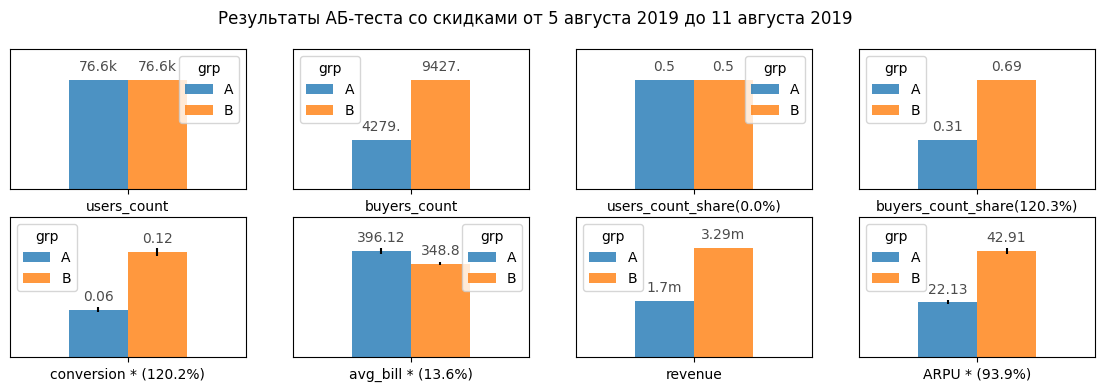

In [ ]:
from matplotlib import gridspec
from math import ceil

# Массив для складирования графиков
ax = []
# Количество картинок в одной линии
n_pict_in_line = 4

# Создаём сетку для графиков
gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line)
fig = plt.figure(figsize=(n_pict_in_line*3 + 2,
                          ceil(len(plot_summary) / n_pict_in_line) * 2))

## Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:
    if 'users_count' != row and 'buyers_count' != row and 'revenue' != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'

fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

## Строим графики
for i, col in enumerate(plot_summary.index):
    # Добавляем subplot в нужную клетку
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line]))
    # Строим график в нужной клетке
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8,
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) # yerr для отображения доверительного интервала на грифике (черная полосочка)


# Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий
    stars = ' * ' if col in significant_changes else ''
    ticks = ax[i].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[i].set_xticklabels(ticks)
    ax[i].set_yticks([])
    # добавляем подписи к столбцам
    set_labels(axes=ax[i])